**CS-401 Applied Data Analysis**  
**Project Milestone 3** 

**Group ID:** TheSuricates  

# **Budget Battles:** Maximizing Returns in Filmmaking Odyssey

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import json

from helpers import convert_to_datetime

### Import TMDB dataset

In [2]:
PATH = './data/'

character = pd.read_csv(PATH + 'tmdb_person.csv')
movie = pd.read_csv(PATH + 'tmdb_movies.csv')

# Cleaning data

We will first remove all the *missing values* (Nans or 0) in the features we will use.

In [3]:
# Remove rows in the movie dataframe containing NaNs on features we will use
cleaned_movie = movie.copy()
cleaned_movie.dropna(subset=['budget', 'revenue', 'release_date', 'runtime',
                              'original_language', 'genres', 'production_countries', 'spoken_languages', 'title'], inplace=True)


# Remove rows in the character dataframe without actor names
cleaned_character = character.copy()
cleaned_character.dropna(subset=['name','birthday', 'gender', 'popularity'], inplace=True)

In [4]:
# Remove rows in the movie dataframe where the revenue or budget are null
cleaned_movie = cleaned_movie[(cleaned_movie['budget'] != 0) & (cleaned_movie['revenue'] != 0)]

# Remove the duplicates
cleaned_movie.drop_duplicates(subset='id', inplace=True)


In [5]:
#restructuring the character dataframe 
cleaned_character['movie_id'] = cleaned_character['played_in_movie_id'].apply(json.loads) #type cast string to list
cleaned_character = cleaned_character.explode('movie_id') #now every row is a different movie id
cleaned_character = cleaned_character.drop('played_in_movie_id', axis=1)

In [6]:
# add the release date to character dataframe
cleaned_movie = cleaned_movie.rename(columns={'id': 'movie_id'})
cleaned_character = cleaned_character.merge(cleaned_movie[['movie_id', 'release_date']],left_on="movie_id",right_on="movie_id",how ="left")
cleaned_character = cleaned_character.rename(columns={'id': 'actor_id'})

# cleaning
cleaned_character.dropna(subset=['release_date'], inplace=True)
cleaned_character.drop_duplicates(subset=['actor_id', 'movie_id'],inplace=True)

# calculate the age of actors in the movie
cleaned_character['age'] = cleaned_character.release_date.apply(convert_to_datetime).dt.year - cleaned_character.birthday.apply(convert_to_datetime).dt.year


# Preparing movie features

Let's create our own dataframe with some features which could have an effect on the `multiplier` of the money earned relative to the money invested in the film.

First we will use features which already exist in the movie metadata : the `runtime`, movie `original language` and `genre`. We will also need to keep the `movie id`, the `title` of the movie, the `release date`, the `budget` and the `revenue` for our analysis.

In [7]:
# Create a new dataframe using movie information
movie_features = cleaned_movie[['movie_id', 'title', 'budget', 'revenue', 'release_date', 'runtime',
                              'original_language', 'genres', 'production_countries', 'spoken_languages']].copy()
movie_features.head()

,movie_id,title,budget,revenue,release_date,runtime,original_language,genres,production_countries,spoken_languages
0,901362.0,Trolls Band Together,95000000.0,107900000.0,2023-10-12,92.0,en,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'..."
1,670292.0,The Creator,80000000.0,104000000.0,2023-09-27,134.0,en,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...","[{'english_name': 'English', 'iso_639_1': 'en'..."
2,872585.0,Oppenheimer,100000000.0,950200000.0,2023-07-19,181.0,en,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...","[{'english_name': 'Dutch', 'iso_639_1': 'nl', ..."
3,507089.0,Five Nights at Freddy's,20000000.0,271900000.0,2023-10-25,110.0,en,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'..."
4,872906.0,Jawan,36150000.0,136698671.0,2023-09-07,169.0,hi,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'iso_3166_1': 'IN', 'name': 'India'}]","[{'english_name': 'Hindi', 'iso_639_1': 'hi', ..."


In [8]:
# Keep the genres,productions_countries and spoken_languages as a list of strings
movie_features['genres'] = movie_features['genres'].str.replace("'", "\"")
movie_features['genres'] = movie_features['genres'].apply(lambda x: [entry['name'] for entry in json.loads(x)])

movie_features['production_countries'] = movie_features['production_countries'].str.replace("'", "\"")
movie_features['production_countries'] = movie_features['production_countries'].apply(lambda x: [entry['name'] for entry in json.loads(x)])

movie_features['spoken_languages'] = movie_features['spoken_languages'].str.replace("'", "\"")
movie_features['spoken_languages'] = movie_features['spoken_languages'].apply(lambda x: [entry['name'] for entry in json.loads(x)])

We will also create new features from the character metadata : 
- the `number of characters` per movie
- the `average experience` of actors : the average upon all actors of the number of movies they appear in (before the movie)
- the `male ratio` of actors
- the `ratio of young actors` (below 18 years old)
- the `ratio of old actors` (above 60 years old)

*** average_age, max_age, min_age, average_popularity, max_popularity, min_popularity, min experience, max_experience***

In [9]:
# Total number of characters, number by age category and by gender
counts = cleaned_character.groupby('movie_id').agg(
    number_characters=('actor_id', 'size'),
    below18=('age', lambda x: (x < 18).sum()),
    above60=('age', lambda x: (x > 60).sum()),
    male_ratio=('gender', lambda x: (x == 2).sum()),
    average_age=('age', 'mean'),
    max_age=('age', 'max'),
    min_age=('age', 'min'),
    average_popularity=('popularity', 'mean'),
    max_popularity=('popularity', 'max'),
    min_popularity=('popularity', 'min')
).reset_index()

# We change the number of characters by age/gender by the ratio above total number of characters
counts['below18'] = counts['below18'] / counts['number_characters']
counts['above60'] = counts['above60'] / counts['number_characters']
counts['male_ratio'] = counts['male_ratio'] / counts['number_characters']

# Add the new columns to our movie_features dataframe
movie_features = pd.merge(movie_features, counts, left_on='movie_id', right_on='movie_id', how='left')

In [10]:
# Actors' experience

# Sort by the date of release (dor) within each actor group
sorted_character = cleaned_character.sort_values(['actor_id', 'release_date'])

# Calculate cumulative count of movies for each actor up to the current movie
sorted_character['cumulative_movie_count'] = sorted_character.groupby('actor_id').cumcount()

# Group by movie (wiki_id) and calculate the mean upon all actors of cumulative movie counts for each movie
means = sorted_character.groupby('movie_id')['cumulative_movie_count'].mean().reset_index()
means.columns = ['movie_id', 'average_actor_exp']
min = sorted_character.groupby('movie_id')['cumulative_movie_count'].min().reset_index()
min.columns = ['movie_id', 'min_actor_exp']
max = sorted_character.groupby('movie_id')['cumulative_movie_count'].max().reset_index()
max.columns = ['movie_id', 'max_actor_exp']
experience_per_movie = pd.merge(means, min, on='movie_id', how='left')
experience_per_movie = pd.merge(experience_per_movie, max, on='movie_id', how='left')

# Merge with the 'movie_features' dataframe
movie_features = pd.merge(movie_features, experience_per_movie, on='movie_id', how='left')
movie_features.head()

,movie_id,title,budget,revenue,release_date,runtime,original_language,genres,production_countries,spoken_languages,...,male_ratio,average_age,max_age,min_age,average_popularity,max_popularity,min_popularity,average_actor_exp,min_actor_exp,max_actor_exp
0,901362.0,Trolls Band Together,95000000.0,107900000.0,2023-10-12,92.0,en,"[Animation, Family, Music, Fantasy, Comedy]",[United States of America],[English],...,0.666667,43.000000,63.0,26.0,18.170133,41.405,11.097,7.133333,0.0,19.0
1,670292.0,The Creator,80000000.0,104000000.0,2023-09-27,134.0,en,"[Science Fiction, Action, Thriller]","[Canada, United States of America]","[English, 日本語, ภาษาไทย, Tiếng Việt]",...,0.600000,44.400000,64.0,9.0,42.415400,200.246,12.063,6.800000,0.0,25.0
2,872585.0,Oppenheimer,100000000.0,950200000.0,2023-07-19,181.0,en,"[Drama, History]","[United Kingdom, United States of America]","[Nederlands, English]",...,0.878049,45.975610,82.0,26.0,31.225268,126.861,10.031,8.585366,0.0,43.0
3,507089.0,Five Nights at Freddy's,20000000.0,271900000.0,2023-10-25,110.0,en,"[Horror, Mystery]",[United States of America],[English],...,0.600000,36.800000,57.0,12.0,56.929800,147.890,16.509,5.600000,0.0,14.0
4,872906.0,Jawan,36150000.0,136698671.0,2023-09-07,169.0,hi,"[Action, Adventure, Thriller]",[India],[हिन्दी],...,0.571429,41.571429,58.0,31.0,17.866000,25.979,11.017,3.000000,0.0,13.0


In [11]:
# Remove nans
movie_features.dropna(inplace=True)

### Plot of the features

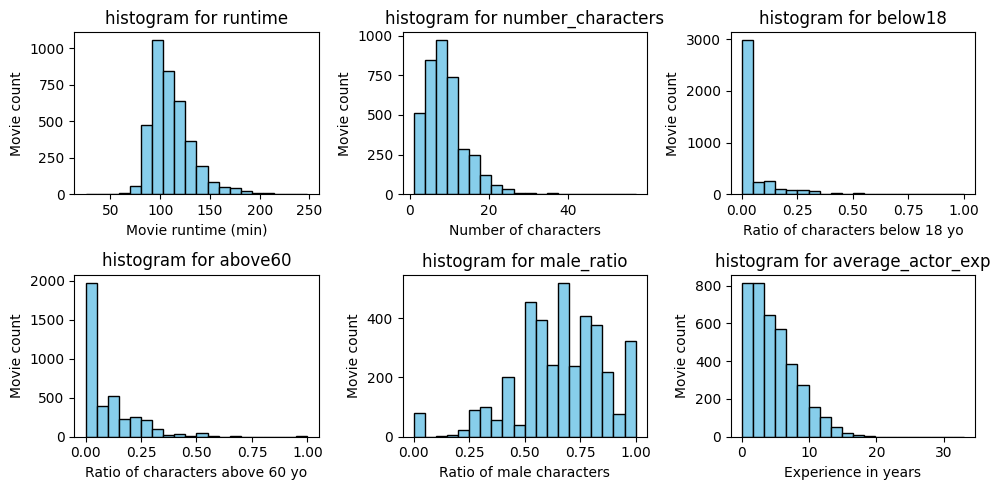

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

# Flatten the axes array for easier indexing
axes = axes.flatten()

list_of_features = ['runtime', 'number_characters', 'below18', 'above60', 'male_ratio', 'average_actor_exp']
list_title = ['Movie runtime (min)', 'Number of characters', 'Ratio of characters below 18 yo','Ratio of characters above 60 yo', 'Ratio of male characters', 'Experience in years']
# Create histograms in each subplot
for i in range(6):
    axes[i].hist(movie_features[list_of_features[i]], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'histogram for {list_of_features[i]}')
    axes[i].set_xlabel(f'{list_title[i]}')
    axes[i].set_ylabel('Movie count')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

We can observe from the histograms above that we have distinct distributions for all the features. This implies that we would be able to optimize the `multiplier` by adjusting the feature values. These will be optimized after the regression.

# Separate low and high budget movies

### Removing outliers

In [13]:
# Create a new column corresponding to the ratio between the revenue and budget of the movie
movie_features['multiplier'] = movie_features['revenue'] / movie_features['budget']

First, we will eliminate outliers from our data concerning the `multiplier` between the `budget` and the `revenue`. To do so, we have to look at our data to understand which values are inaccurate.

For example, upon the highest multipliers some may be accurate. The movie *Paranormal activity* is known as one of the most profitable movies, as it used found-footage and was a huge success (multiplier of 900). This kind of information is very interesting for our analysis. We will only remove multipliers above 1000.

Upon the lowest multipliers, from a revenue of 10% of the budget (multiplier of 0.1), we can consider that the values are accurate. 

In [14]:
# Remove outliers of the multiplier of our movie features
lower_bound = 0.1
upper_bound = 1000

movie_features_no_outliers = movie_features[(movie_features['multiplier'] > lower_bound) & 
                                            (movie_features['multiplier'] < upper_bound)].copy()

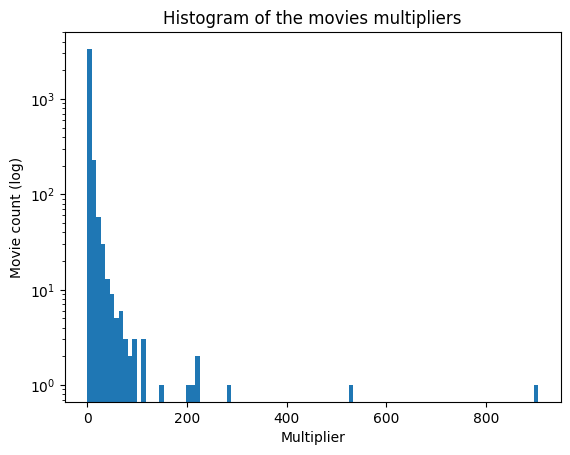

In [15]:
# Plot the multipliers distributions 
plt.hist(movie_features_no_outliers.multiplier, bins=100)
plt.title('Histogram of the movies multipliers')
plt.xlabel('Multiplier')
plt.ylabel('Movie count (log)')
plt.yscale('log')
plt.show()

We can also remove movies with budget lower than 10000$.

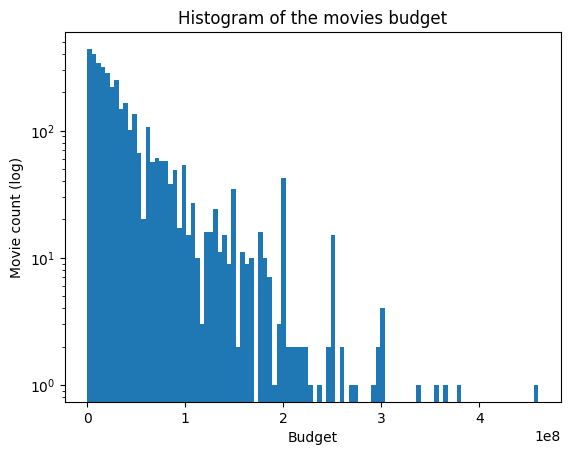

In [16]:
movie_features_no_outliers = movie_features_no_outliers[movie_features_no_outliers['budget'] > 10000]

# Plot the budget distributions 
plt.hist(movie_features_no_outliers.budget, bins=100)
plt.title('Histogram of the movies budget')
plt.xlabel('Budget')
plt.ylabel('Movie count (log)')
plt.yscale('log')
plt.show()

In [17]:
print('There remain {} movies in the movie_features_no_outliers dataset.'.format(len(movie_features_no_outliers)))

There remain 3712 movies in the movie_features_no_outliers dataset.


### Movie distribution over the years

In [18]:
# Convert the movies date of release to datetime
movie_features_no_outliers['release_date'] = movie_features_no_outliers['release_date'].apply(convert_to_datetime)

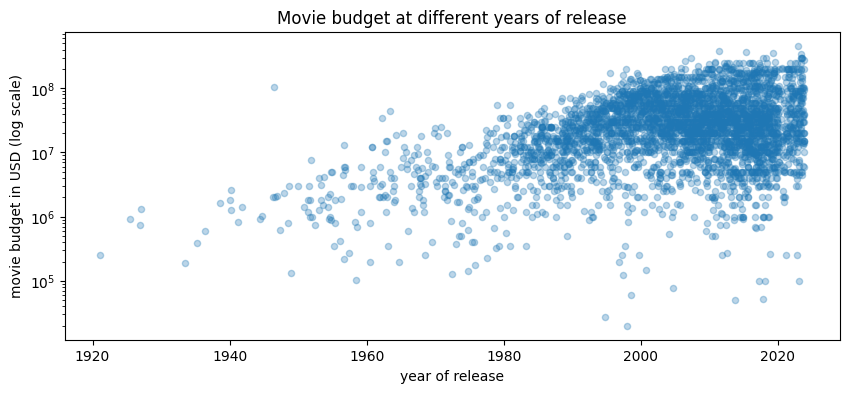

In [19]:
# Plot the movie budget at different years of release
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(movie_features_no_outliers['release_date'], movie_features_no_outliers['budget'], alpha=0.3, s=20)
plt.title('Movie budget at different years of release')
plt.xlabel('year of release')
plt.ylabel('movie budget in USD (log scale)')
plt.yscale('log')
plt.show()

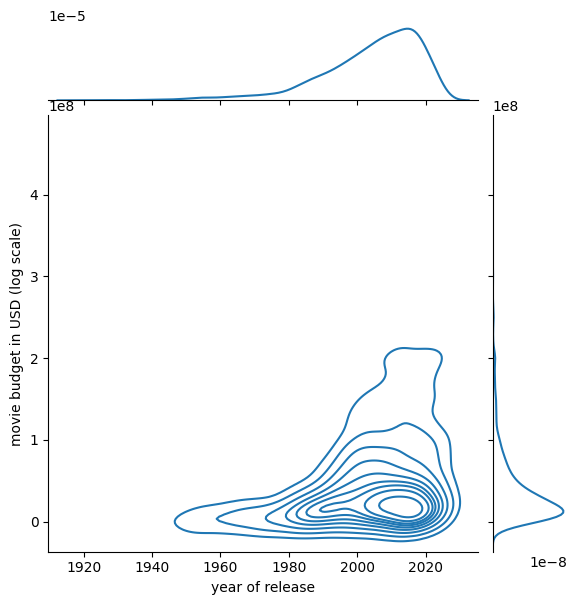

In [20]:
# Let's plot the movie budget in another way to better see the distribution
sns.jointplot(data=movie_features_no_outliers, x='release_date', y='budget', kind='kde').set_axis_labels('year of release', 'movie budget in USD (log scale)')
plt.show()

The scatterplot gave us a first insight about the data distribution over the years. The graph above draws both bivariate and univariate Kernel Density Estimations (KDEs) to have a smoother and cleaner representation of the movie budget data over the years.

### Removing old movies

Our objective is to identify how to maximize returns on investment nowadays. Considering older movies may introduce bias into our analysis, as they adhere to different norms, and audience preferences have evolved over time. We will then exclude all movies released before 1980 from our analysis.

In [21]:
# Remove old movies
new_movie_features = movie_features_no_outliers[movie_features_no_outliers['release_date'] > convert_to_datetime('1980')].copy()

### Separate in low and high budget categories

To distinguish between `low` and `high`-budget films, we categorize films into five-year groups based on their release dates. The top 40% of films with the highest budgets and the bottom 40% with the lowest budgets are then identified within each time frame. This process mitigates the impact of ***inflation*** on budget categorization. Subsequently, all high-budget films from different periods will be regrouped into a single high-budget category, and the same will be done for low-budget films.

In [22]:
min_year = new_movie_features['release_date'].min().year
max_year = new_movie_features['release_date'].max().year

# Create a new column corresponding to the year of release of the movie
new_movie_features['year'] = new_movie_features['release_date'].dt.year 
new_movie_features['year_group'] = new_movie_features['year']

df_low_budget_movie = pd.DataFrame(columns=new_movie_features.columns)
df_high_budget_movie = pd.DataFrame(columns=new_movie_features.columns)

year = min_year
while year < max_year:
    # Select movies released by 5 years interval
    movies = new_movie_features[(new_movie_features['year'] >= int(year)) & (new_movie_features['year'] < int(year + 5))]
    # Add the movies with the highest and lowest budget to the corresponding dataframe
    movies['year_group'] = year
    df_high_budget_movie = pd.concat([pd.DataFrame(movies[movies['budget'] > movies['budget'].quantile(0.6)]),df_high_budget_movie], ignore_index=True)
    df_low_budget_movie = pd.concat([pd.DataFrame(movies[movies['budget'] < movies['budget'].quantile(0.4)]),df_low_budget_movie], ignore_index=True)
    year += 5


C:\Users\jojod\AppData\Local\Temp\ipykernel_29548\224010811.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['year_group'] = year
C:\Users\jojod\AppData\Local\Temp\ipykernel_29548\224010811.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_high_budget_movie = pd.concat([pd.DataFrame(movies[movies['budget'] > movies['budget'].quantile(0.6)]),df_high_budget_movie], ignore_index=True)
C:\Users\jojod\AppData\Local\Temp\ipykernel_29548\224010811.py:18: FutureWarning: The behavior of DataFr

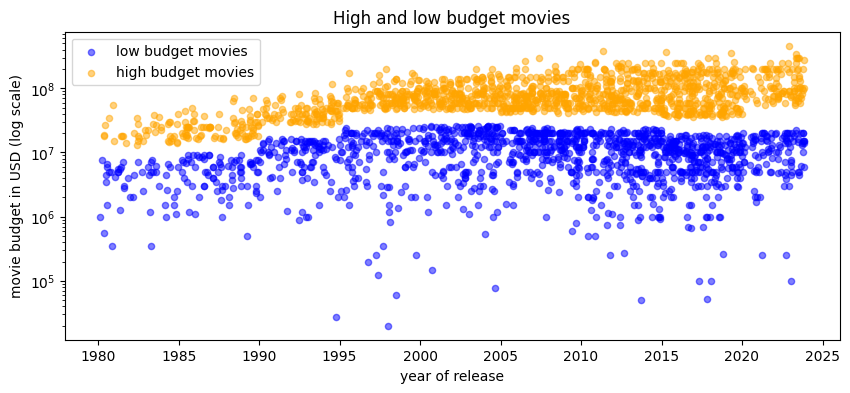

In [23]:
# Plot the high and low budget movies at different years of release
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(df_low_budget_movie['release_date'], df_low_budget_movie['budget'], label='low budget movies', color='blue', alpha=0.5, s=20)
plt.scatter(df_high_budget_movie['release_date'], df_high_budget_movie['budget'], label='high budget movies', color='orange', alpha=0.5, s=20)
plt.title('High and low budget movies')
plt.xlabel('year of release')
plt.ylabel('movie budget in USD (log scale)')
plt.yscale('log')
plt.legend()
plt.show()

We observe a distinct separation between `low` and `high` budgets. The graph illustrates that the definition of low and high budgets changes over the years, following a logarithmic function.


In [24]:
print('There are {} low budget movies.'.format(len(df_low_budget_movie)))
print('There are {} high budget movies.'.format(len(df_high_budget_movie)))

There are 1349 low budget movies.
There are 1308 high budget movies.


In [25]:
df_low_budget_movie['category'] = 'low'
df_high_budget_movie['category'] = 'high'
df = pd.concat([df_low_budget_movie, df_high_budget_movie], ignore_index=True) 

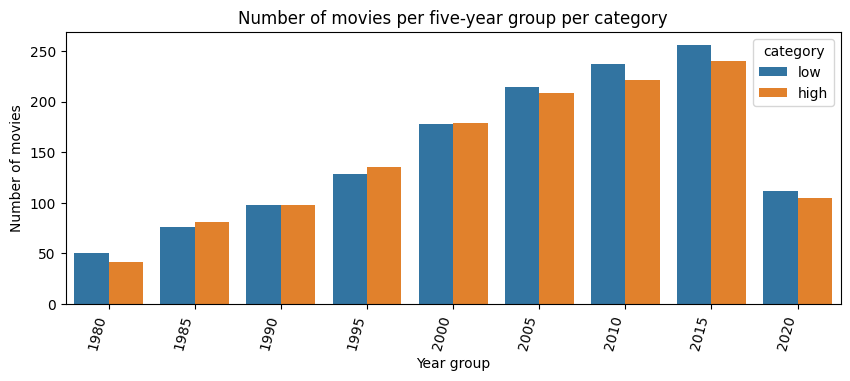

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(data=df, x='year_group', hue='category')
ax.set_title('Number of movies per five-year group per category')
ax.set_xlabel('Year group')
ax.set_ylabel('Number of movies')
fig.autofmt_xdate(rotation = 75)

By selecting the 40% lowest and highest values for each five-year group, we approximately have the same number of films from each year group. The higher count of films in recent years is attributed to the greater number of films recorded in the dataset from those years.

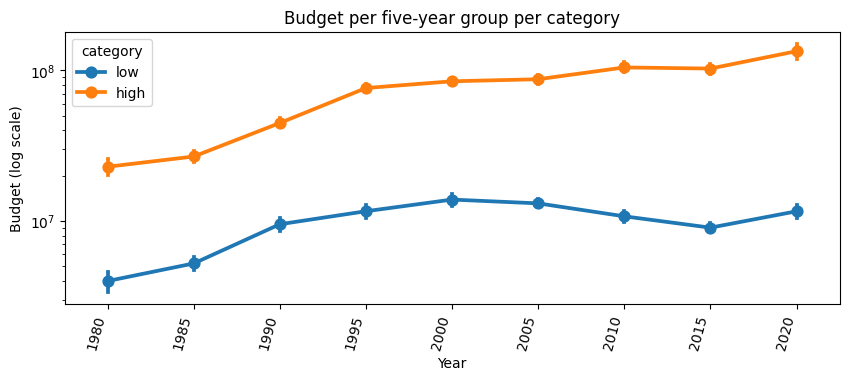

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))

# Ploting the corresponding fraction of missing salary by year
sns.pointplot(data=df, x='year_group', y='budget', hue='category', errorbar=('ci', 95))

ax.set_title('Budget per five-year group per category')
ax.set_xlabel('Year')
ax.set_yscale('log')
ax.set_ylabel('Budget (log scale)')
ax.legend(title='category')

fig.autofmt_xdate(rotation = 75)

plt.show()

We can observe from the above graph that films with high and low budgets have non-overlapping 95% confidence intervals. This indicates that the films are effectively distinguished.